In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.stats as ss

In [2]:
# load your data (don't touch, just run)

"""
data = []
f = open('covtype.data','r')
while(1):
    line = f.readline()
    if  len(line) < 100:
        print line
    
    if len(line) == 0: break
    data.append(np.array([float(k) for k in line.split(',')]))
    if len(data) % 100000 == 0:
        print len(data)
        
f.close
data = np.vstack(data)
N = data.shape[0]
idx = np.random.permutation(N)


X_test = data[:N/5,:]
X_train = data[N/5:,:]
y_test = X_test[:,-1]
y_train = X_train[:,-1]
X_test = X_test[:,:-1]
X_train = X_train[:,:-1]


sio.savemat('covtype.mat',{'X_train':X_train,'X_test':X_test,'y_train':y_train,'y_test':y_test})
data = sio.loadmat('covtype.mat')
X_train = data['X_train'][:100,:]
X_test = data['X_test'][:100,:]
y_train = data['y_train'][0][:100]
y_test = data['y_test'][0][:100]
print X_train.shape, X_test.shape, y_train.shape, y_test.shape
sio.savemat('covtype_reduced.mat',{'X_train':X_train,'X_test':X_test,'y_train':y_train,'y_test':y_test})
"""



data = sio.loadmat('covtype_reduced.mat')
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train'][0][:]
y_test = data['y_test'][0][:]

print X_train.shape, X_test.shape, y_train.shape, y_test.shape


(468L, 54L) (116202L, 54L) (468L,) (116202L,)


In [3]:
def entropy(y):
    m = len(y)
    K = len(set(y))
   
    if m == 1: return 0.
    
    total_term = 0.
    for k in xrange(K):
        p = sum(np.equal(y,k))/(m+0.)
        term = p*np.log2(p) if p > 0. else 0.
        total_term -= term
        
    return total_term

def cond_entropy(y,yhat):
    m = len(y)
    K = len(set(y))
    Khat = len(set(yhat))
    if m == 1: 
        return 0.
    
    total_term = 0.
    for i in xrange(K):
        if sum(np.equal(y,i)) == 0.:
            continue
        u = np.equal(y,i)
        for j in xrange(Khat):
            if sum(np.equal(yhat,j)) == 0.:
                continue
            v = np.equal(yhat,j)
            uv = np.logical_and(u,v)
            if sum(uv) == 0: 
                continue
            pugv = np.sum(uv)/(np.sum(v)+0.)
            puv = np.sum(uv)/ (m+0.) 
            
            term = puv*np.log2(pugv)
            total_term -= term
    return total_term

#random_sequence_1 = (np.random.rand(1000)*10).astype(int)
#random_sequence_2 = (np.random.rand(1000)*2).astype(int)
#sio.savemat('random_sequences.mat',{'s1':random_sequence_1,'s2':random_sequence_2})

random_sequences = sio.loadmat('random_sequences.mat')

s1 = random_sequences['s1'][0]
s2 = random_sequences['s2'][0]

print 'entropy = ', entropy(s1)
print 'conditional entropy = ', cond_entropy(s1,s2)


entropy =  3.314182323161083
conditional entropy =  3.3029598816135173


In [9]:
def find_best_split(x,y):
    discretize = 10
    nfeat = x.shape[1]
    score = np.zeros((discretize,nfeat))
    
    best_split = np.zeros(nfeat)
    best_score = np.zeros(nfeat)
    for feat in xrange(nfeat):
        splitrange = np.linspace(min(x[:,feat]),max(x[:,feat]),discretize)
        score = splitrange * 0.
        for i in xrange(len(splitrange)):
            s = splitrange[i]
            yhat = np.less(x[:,feat] ,s)
            score[i] = entropy(y) - cond_entropy(y,yhat)

        best_split_idx = np.argmax(score)
        best_split[feat] = splitrange[best_split_idx]
        best_score[feat] = score[best_split_idx]
    best_feat = np.argmax(best_score)
    splitval = best_split[best_feat]
    
    set1 = np.where(np.less(x[:,best_feat],splitval))[0]
    set2 = np.where(np.greater_equal(x[:,best_feat],splitval))[0]
    if min(len(set1), len(set2)) == 0:
        return None, None, None, None
    return best_feat, splitval, set1, set2


best_feat, splitval, set1, set2 = find_best_split(X_train, y_train)
print best_feat, splitval
y_new = y_train * 0
y_new[set1] = 1
print 'information gained in first step', entropy(y_train) - cond_entropy(y_train,y_new)

0 2852.1111111111113
information gained in first step 0.3194893606666638


In [10]:
def purity(y):
    return ss.mode(y)[1][0]/(len(y)+0.)
    

class Node:
    def __init__(self,  sample_idx, nodeid,  is_leaf = True):
        self.is_leaf = is_leaf
        self.id = nodeid
        self.sample_idx = sample_idx
        self.children = []
        self.splitable = True
        
        
    def visit_node(self, x):
        if self.is_leaf:
            return self.label
        decision = self.split_rule(x)
        return self.children[decision].visit_node(x)
        
    def split_rule(self,x):
        return 0 if x[self.splitfeat] < self.splitval else 1
            
    
    def add_split_details(self, splitfeat, splitval)  :
        self.splitfeat = splitfeat
        self.splitval = splitval
        
        
        
class Tree:
    def __init__(self, x,y):
        m = len(y)
        self.x = x
        self.y = y
        self.maxid = -1
        self.root = self.construct_node(np.array(range(m)))
        self.leaves = [self.root]
        
    def print_tree(self):
        print 'printing tree...'
        def print_node(parent, node):
            print node.id, 
            
            if parent is not None:
                print ', parent ', parent.id,
            else:
                print ', ROOT', 
                
            print ', label ', node.label, 
            if node.is_leaf: 
                print ', LEAF, ', 'nsamples %d, purity %.2f' %(len(node.sample_idx), purity(self.y[node.sample_idx]))
            else:
                print ', NONLEAF, split %d, val %.2f' % (node.splitfeat, node.splitval)
            if not node.is_leaf:
                for ch in node.children:
                    print_node(node, ch)
        print_node(None, self.root)
    def construct_node(self, sample_idx):
        node = Node(sample_idx, self.maxid + 1,  True)
      
        node.label = ss.mode(self.y[sample_idx])[0][0]
        node.entropy = entropy(self.y[sample_idx])
        
        node.num_mistakes = np.sum(np.not_equal(node.label, self.y[sample_idx]))
        self.maxid += 1
        return node
        


    def report_train_err(self):
        total_mistakes = 0
        for leaf in self.leaves:
            total_mistakes += leaf.num_mistakes
        return total_mistakes / (len(self.y)+0.)
        
    def update_leaf(self, which_leaf):
        leaf = self.leaves[which_leaf]
        splitfeat, splitval,set1,set2 = find_best_split(self.x[leaf.sample_idx,:],self.y[leaf.sample_idx])
        if splitfeat is None:
            leaf.splitable = False
            return None, None
        leaf.add_split_details(splitfeat, splitval)
        leaf.is_leaf = False
    
        set1 = leaf.sample_idx[set1]
        set2 = leaf.sample_idx[set2]
     
        leaf.children.append(self.construct_node(set1))
        leaf.children.append(self.construct_node(set2))
        
        self.leaves.pop(which_leaf)
        self.leaves.extend(leaf.children)

        return splitfeat, splitval
    
    def report_worst_leaf(self):
        worst_leaf_score = -np.inf
        worst_leaf = None
        for l in xrange(len(self.leaves)):
            leaf = self.leaves[l]
            if leaf.splitable:
                leaf_score = leaf.entropy
                if leaf_score > worst_leaf_score:
                    worst_leaf = l
                    worst_leaf_score = leaf_score
        return worst_leaf
        
    
    def predict(self,x):
        return self.root.visit_node(x)


    

In [11]:
def get_test_err(tree):
    # get test error
    num_test_mistakes = 0
    for k in xrange(len(y_test)):
        x,y = X_test[k,:],y_test[k]
        if y != tree.predict(x):
            num_test_mistakes += 1
    return num_test_mistakes / (len(y_test)+0.)



tree = Tree(X_train,y_train)
tree.print_tree()
print 'current train err:', tree.report_train_err()
print 'current test err:', get_test_err(tree)


# my first split
best_feat, splitval, set1, set2 = find_best_split(X_train, y_train)
 
left_child = tree.construct_node(set1)
right_child = tree.construct_node(set2)
tree.root.is_leaf = False
tree.leaves.pop(tree.leaves.index(tree.root))
tree.root.add_split_details(splitfeat = best_feat, splitval = splitval)


tree.root.children = [left_child, right_child]
tree.leaves.extend(tree.root.children)
tree.print_tree()
print 'one step train err:', tree.report_train_err()
print 'one step test err:', get_test_err(tree)





printing tree...
0 , ROOT , label  2.0 , LEAF,  nsamples 468, purity 0.44
current train err: 0.5641025641025641
current test err: 0.313806991274
printing tree...
0 , ROOT , label  2.0 , NONLEAF, split 0, val 2852.11
1 , parent  0 , label  2.0 , LEAF,  nsamples 119, purity 0.46
2 , parent  0 , label  1.0 , LEAF,  nsamples 349, purity 0.51
one step train err: 0.5
one step test err: 0.486463227827


In [12]:


misclass_train = []
misclass_test = []
tree = Tree(X_train,y_train)
misclass_train.append(tree.report_train_err())
misclass_test.append(get_test_err(tree))


for iter in xrange(100):
    print 'iter', iter
    split = None
    while split is None:
        next_split = tree.report_worst_leaf()
        if next_split is None: 
            print 'terminated'
            break
        split, val = tree.update_leaf(next_split)
    
    if next_split is None: 
        print 'terminated'
        break
        
    misclass_train.append(tree.report_train_err())
    misclass_test.append(get_test_err(tree))



iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24
iter 25
iter 26
iter 27
iter 28
iter 29
iter 30
iter 31
iter 32
iter 33
iter 34
iter 35
iter 36
iter 37
iter 38
iter 39
iter 40
iter 41
iter 42
iter 43
iter 44
iter 45
iter 46
iter 47
iter 48
iter 49
iter 50
iter 51
iter 52
iter 53
iter 54
iter 55
iter 56
iter 57
iter 58
iter 59
iter 60
iter 61
iter 62
iter 63
iter 64
iter 65
iter 66
iter 67
iter 68
iter 69
iter 70
iter 71
iter 72
iter 73
iter 74
iter 75
iter 76
iter 77
iter 78
iter 79
iter 80
iter 81
iter 82
iter 83
iter 84
iter 85
iter 86
iter 87
iter 88
iter 89
iter 90
iter 91
iter 92
iter 93
iter 94
iter 95
iter 96
iter 97
iter 98
iter 99


[0.5641025641025641, 0.5, 0.4594017094017094, 0.4594017094017094, 0.45085470085470086, 0.4465811965811966, 0.3418803418803419, 0.33760683760683763, 0.33760683760683763, 0.33760683760683763, 0.3333333333333333, 0.32905982905982906, 0.32905982905982906, 0.32905982905982906, 0.32051282051282054, 0.3141025641025641, 0.31196581196581197, 0.30982905982905984, 0.3055555555555556, 0.3055555555555556, 0.297008547008547, 0.297008547008547, 0.29273504273504275, 0.2905982905982906, 0.2905982905982906, 0.2841880341880342, 0.2841880341880342, 0.2841880341880342, 0.27564102564102566, 0.27136752136752135, 0.27136752136752135, 0.2692307692307692, 0.2692307692307692, 0.2670940170940171, 0.26282051282051283, 0.26282051282051283, 0.26282051282051283, 0.2606837606837607, 0.25854700854700857, 0.2564102564102564, 0.2564102564102564, 0.25427350427350426, 0.25213675213675213, 0.25213675213675213, 0.24786324786324787, 0.24786324786324787, 0.24358974358974358, 0.24145299145299146, 0.23717948717948717, 0.22222222

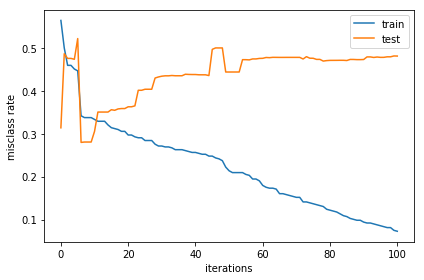

In [13]:
print misclass_train
print misclass_test
tree.print_tree()
plt.plot(misclass_train)
plt.plot(misclass_test)
plt.xlabel('iterations')
plt.ylabel('misclass rate')
plt.legend(['train','test'])
plt.tight_layout()
plt.savefig('decision_tree_covertype.png')